# Day 7: Interview Questions & Week Review
## Week 3: Time Series Analysis for Finance

---

### 🎯 Today's Focus
- Review key concepts from the week
- Practice interview questions
- Apply concepts to real scenarios
- Build intuition for quant interviews

---

### 📈 Why Interview Practice Matters

**Time Series in Quant Interviews:**

Time series concepts appear in ~80% of quant trading interviews. Interviewers test:

| What They Test | Why It Matters |
|----------------|----------------|
| Stationarity understanding | Foundation of all time series work |
| Model selection (AR/MA/ARMA) | Can you identify patterns? |
| GARCH knowledge | Risk management competency |
| Cointegration | Pairs trading is core strategy |

### How to Answer Interview Questions

| Step | What to Do |
|------|------------|
| **1. Define** | What is the concept? (1 sentence) |
| **2. Explain** | Why does it matter? (business context) |
| **3. Example** | Give a concrete trading example |
| **4. Caution** | What can go wrong? (shows experience) |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


---
## 📚 Week 3 Concept Summary

### Quick Reference for Interviews

| Day | Topic | Interview Keywords | Trading Use |
|-----|-------|-------------------|-------------|
| 1 | Stationarity | ADF, KPSS, unit root, I(d) | Data preprocessing |
| 2 | ACF/PACF | Correlograms, lags, cutoff/decay | Model identification |
| 3 | ARMA | AR, MA, AIC/BIC, parsimony | Return forecasting |
| 4 | ARIMA | Differencing, forecasting, rolling | Price forecasting |
| 5 | GARCH | Vol clustering, persistence, VaR | Risk management |
| 6 | Cointegration | Engle-Granger, hedge ratio, spread | Pairs trading |

### Interview Sound Bites

| Question Topic | One-Liner Answer |
|----------------|------------------|
| "What is stationarity?" | "Constant mean and variance over time" |
| "How do you test for it?" | "ADF test - reject null means stationary" |
| "AR vs MA?" | "AR = past values, MA = past shocks" |
| "What does d mean in ARIMA?" | "Number of differences to make stationary" |
| "Explain GARCH" | "Tomorrow's vol depends on today's vol + today's shock" |
| "Cointegration vs correlation?" | "Correlation is short-term, cointegration is long-term equilibrium" |

---
## 🎯 Interview Question 1: Stationarity

**Q: "Why can't you use stock prices directly in a regression model? What should you do instead?"**

### How to Structure Your Answer

| Part | What to Say |
|------|-------------|
| **Problem** | Prices are non-stationary (unit root) |
| **Consequence** | Spurious regression, invalid statistics |
| **Solution** | Use returns instead |
| **Bonus Point** | Mention ADF test to verify |

### Follow-up Questions to Expect

| Follow-up | Your Answer |
|-----------|-------------|
| "How do you test for stationarity?" | ADF test (reject H0 = stationary) |
| "What if ADF fails?" | Use KPSS as confirmation |
| "What's the difference?" | ADF: H0=unit root, KPSS: H0=stationary |

In [2]:
# Demonstrate the answer
print("=" * 60)
print("INTERVIEW Q1: STATIONARITY")
print("=" * 60)

aapl_price = prices['AAPL']
aapl_return = returns['AAPL']

# Test stationarity
price_adf = adfuller(aapl_price)[1]
return_adf = adfuller(aapl_return.dropna())[1]

print("\n✅ ANSWER:")
print("-" * 50)
print("Stock prices are NON-STATIONARY (they have a unit root):")
print(f"  Price ADF p-value: {price_adf:.4f} (fail to reject H0: non-stationary)")
print(f"  Return ADF p-value: {return_adf:.6f} (reject H0 → stationary)")

print("\n📌 Key Points:")
print("  1. Non-stationary data leads to SPURIOUS REGRESSIONS")
print("  2. Standard errors are invalid")
print("  3. R² is inflated (looks good but meaningless)")
print("\n📌 Solution: Use RETURNS instead of prices")
print("  • Returns = (Pt - Pt-1) / Pt-1")
print("  • Log returns = ln(Pt / Pt-1)")
print("  • Both are stationary for financial data")

INTERVIEW Q1: STATIONARITY

✅ ANSWER:
--------------------------------------------------
Stock prices are NON-STATIONARY (they have a unit root):
  Price ADF p-value: 0.7081 (fail to reject H0: non-stationary)
  Return ADF p-value: 0.000000 (reject H0 → stationary)

📌 Key Points:
  1. Non-stationary data leads to SPURIOUS REGRESSIONS
  2. Standard errors are invalid
  3. R² is inflated (looks good but meaningless)

📌 Solution: Use RETURNS instead of prices
  • Returns = (Pt - Pt-1) / Pt-1
  • Log returns = ln(Pt / Pt-1)
  • Both are stationary for financial data


---
## 🎯 Interview Question 2: ACF/PACF

**Q: "You observe ACF that decays slowly and PACF that cuts off after lag 2. What model would you fit?"**

### How to Structure Your Answer

| Part | What to Say |
|------|-------------|
| **Pattern Recognition** | Decaying ACF + cutoff PACF = AR model |
| **Model Order** | PACF cuts at lag 2 → AR(2) |
| **Intuition** | Current value depends on 2 past values |

### The Master Table (Memorize This!)

| ACF Pattern | PACF Pattern | Model |
|-------------|--------------|-------|
| Decays exponentially | Cuts off at p | **AR(p)** |
| Cuts off at q | Decays exponentially | **MA(q)** |
| Both decay | Both decay | **ARMA(p,q)** |

### Common Follow-ups

| Follow-up | Your Answer |
|-----------|-------------|
| "What if both cut off?" | Could be ARMA, use AIC/BIC |
| "How do you choose p and q?" | Grid search with AIC/BIC |
| "AR(2) in trading?" | Price depends on last 2 days' prices |

INTERVIEW Q2: ACF/PACF INTERPRETATION


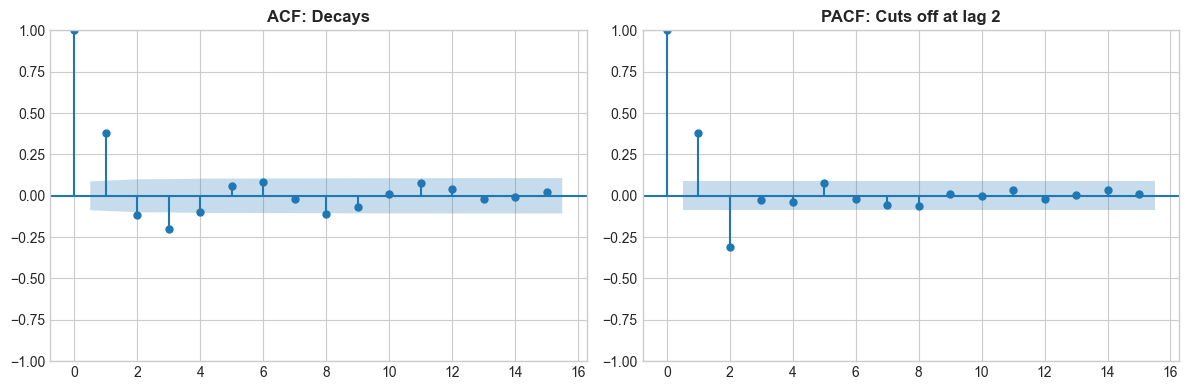


✅ ANSWER: AR(2) model
--------------------------------------------------

📌 Pattern Recognition Rules:

  | ACF Pattern  | PACF Pattern | Model |
  |--------------|--------------|-------|
  | Decays       | Cuts at p    | AR(p) |  ← This case!
  | Cuts at q    | Decays       | MA(q) |
  | Both decay   | Both decay   | ARMA  |

📌 Remember:
  • PACF 'cuts off' means becomes insignificant after lag p
  • ACF 'decays' means exponential or oscillating decay


In [3]:
# Demonstrate
print("=" * 60)
print("INTERVIEW Q2: ACF/PACF INTERPRETATION")
print("=" * 60)

# Simulate AR(2) to show the pattern
np.random.seed(42)
n = 500
ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = 0.5 * ar2[t-1] - 0.3 * ar2[t-2] + np.random.randn()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ar2, lags=15, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: Decays', fontweight='bold')
plot_pacf(ar2, lags=15, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF: Cuts off at lag 2', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ ANSWER: AR(2) model")
print("-" * 50)
print("\n📌 Pattern Recognition Rules:")
print("\n  | ACF Pattern  | PACF Pattern | Model |")
print("  |--------------|--------------|-------|")
print("  | Decays       | Cuts at p    | AR(p) |  ← This case!")
print("  | Cuts at q    | Decays       | MA(q) |")
print("  | Both decay   | Both decay   | ARMA  |")

print("\n📌 Remember:")
print("  • PACF 'cuts off' means becomes insignificant after lag p")
print("  • ACF 'decays' means exponential or oscillating decay")

---
## 🎯 Interview Question 3: GARCH

**Q: "What is volatility clustering? How does GARCH capture it?"**

### How to Structure Your Answer

| Part | What to Say |
|------|-------------|
| **Definition** | Large moves follow large moves |
| **Evidence** | Returns uncorrelated, squared returns correlated |
| **GARCH formula** | σ²ₜ = ω + αε²ₜ₋₁ + βσ²ₜ₋₁ |
| **Trading use** | VaR calculation, position sizing |

### Parameter Interpretation

| Parameter | Meaning | Typical Value |
|-----------|---------|---------------|
| **α (alpha)** | Shock impact | 0.05 - 0.15 |
| **β (beta)** | Persistence | 0.80 - 0.95 |
| **α + β** | Total persistence | ~0.95 |

### Common Follow-ups

| Follow-up | Your Answer |
|-----------|-------------|
| "What's the unconditional vol?" | σ² = ω/(1-α-β) |
| "Why GARCH(1,1)?" | Simple, works well, industry standard |
| "Extensions?" | EGARCH for leverage effect |

INTERVIEW Q3: VOLATILITY CLUSTERING


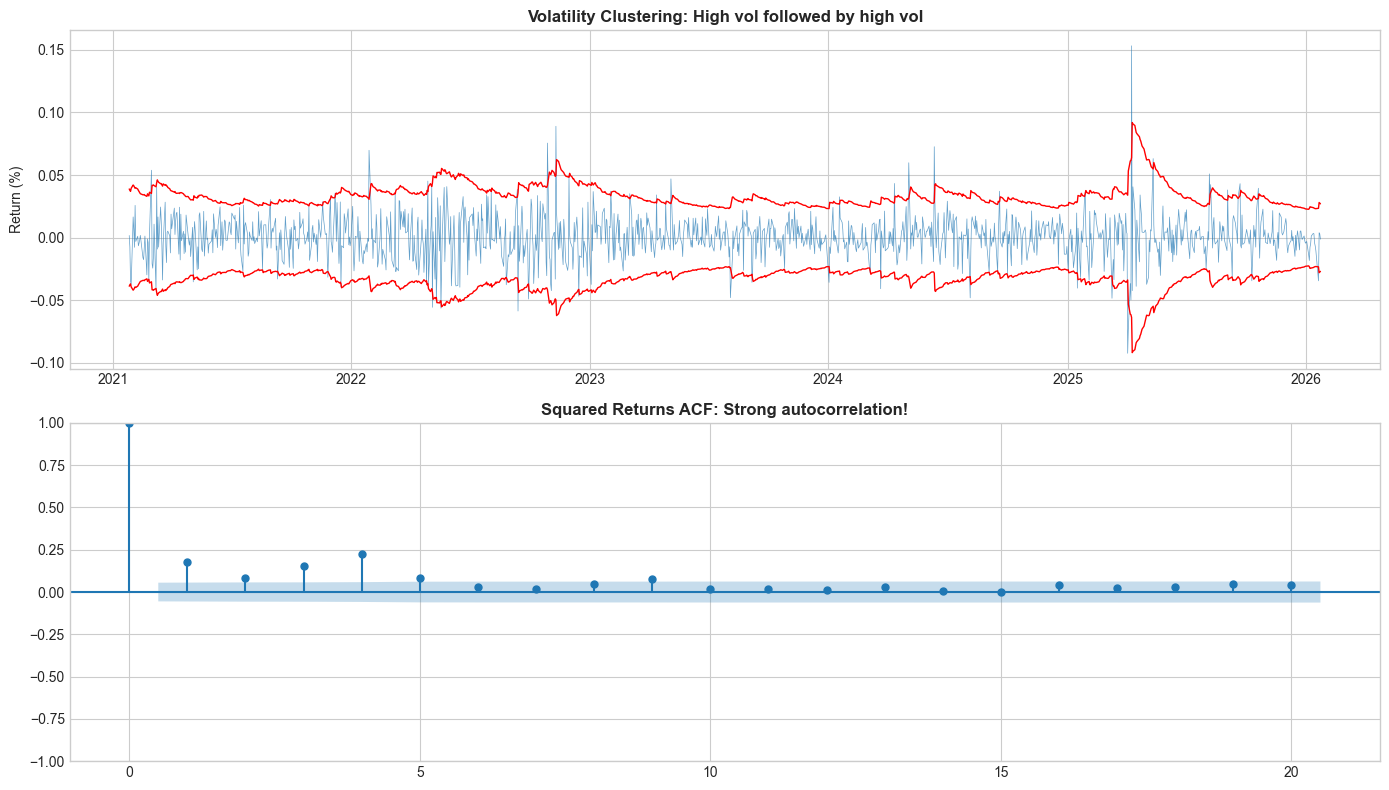


✅ ANSWER:
--------------------------------------------------

📌 Volatility Clustering:
  • Large returns (+ or -) tend to follow large returns
  • Small returns tend to follow small returns
  • Returns themselves may be unpredictable...
  • But VOLATILITY is predictable!

📌 How GARCH captures it:
  σ²ₜ = ω + α·ε²ₜ₋₁ + β·σ²ₜ₋₁

  • α: Reaction to recent shocks (ε²ₜ₋₁)
  • β: Persistence of volatility (σ²ₜ₋₁)

  Current model: α = 0.0500, β = 0.9300
  Persistence (α + β) = 0.9800


In [4]:
# Demonstrate volatility clustering
print("=" * 60)
print("INTERVIEW Q3: VOLATILITY CLUSTERING")
print("=" * 60)

aapl_ret = returns['AAPL']

# Fit GARCH(1,1)
garch = arch_model(aapl_ret.dropna(), vol='GARCH', p=1, q=1)
fit = garch.fit(disp='off')

cond_vol = fit.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns with vol bands
axes[0].plot(aapl_ret, lw=0.5, alpha=0.7)
axes[0].plot(cond_vol.index, 2*cond_vol, 'r-', lw=1)
axes[0].plot(cond_vol.index, -2*cond_vol, 'r-', lw=1)
axes[0].set_title('Volatility Clustering: High vol followed by high vol', fontweight='bold')
axes[0].set_ylabel('Return (%)')

# ACF comparison
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(aapl_ret.dropna()**2, lags=20, ax=axes[1], alpha=0.05)
axes[1].set_title('Squared Returns ACF: Strong autocorrelation!', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ ANSWER:")
print("-" * 50)
print("\n📌 Volatility Clustering:")
print("  • Large returns (+ or -) tend to follow large returns")
print("  • Small returns tend to follow small returns")
print("  • Returns themselves may be unpredictable...")
print("  • But VOLATILITY is predictable!")

print("\n📌 How GARCH captures it:")
print("  σ²ₜ = ω + α·ε²ₜ₋₁ + β·σ²ₜ₋₁")
print("\n  • α: Reaction to recent shocks (ε²ₜ₋₁)")
print("  • β: Persistence of volatility (σ²ₜ₋₁)")
print(f"\n  Current model: α = {fit.params['alpha[1]']:.4f}, β = {fit.params['beta[1]']:.4f}")
print(f"  Persistence (α + β) = {fit.params['alpha[1]'] + fit.params['beta[1]']:.4f}")

---
## 🎯 Interview Question 4: Cointegration

**Q: "Two stocks have a correlation of 0.95. Can you use them for pairs trading?"**

### How to Structure Your Answer

| Part | What to Say |
|------|-------------|
| **Initial Answer** | "Not necessarily" - shows sophistication |
| **Explanation** | Correlation ≠ Cointegration |
| **Key Difference** | Correlation is short-term, cointegration is long-term equilibrium |
| **Test to Use** | Engle-Granger or Johansen cointegration test |

### The Killer Distinction

| Property | Correlation | Cointegration |
|----------|-------------|---------------|
| Measures | Co-movement | Long-run equilibrium |
| Time frame | Instantaneous | Persistent |
| Spread behavior | Can drift forever | Mean-reverts |
| For pairs trading | Risky | Reliable |

### Common Follow-ups

| Follow-up | Your Answer |
|-----------|-------------|
| "How to test?" | Engle-Granger: regress Y on X, test residuals for stationarity |
| "What's the hedge ratio?" | β from regression Y = α + βX |
| "When does pairs trading fail?" | Cointegration breaks down (structural change) |

In [5]:
# Demonstrate
print("=" * 60)
print("INTERVIEW Q4: CORRELATION vs COINTEGRATION")
print("=" * 60)

# AAPL and MSFT are highly correlated
corr = prices['AAPL'].corr(prices['MSFT'])
coint_pval = coint(prices['AAPL'], prices['MSFT'])[1]

print("\n✅ ANSWER: Not necessarily!")
print("-" * 50)
print(f"\nExample: AAPL vs MSFT")
print(f"  Correlation:     {corr:.4f} (very high!)")
print(f"  Cointegration p: {coint_pval:.4f}")

print("\n📌 Key Insight:")
print("  • Correlation = short-term co-movement")
print("  • Cointegration = long-term equilibrium relationship")
print("\n📌 For pairs trading, you need COINTEGRATION:")
print("  • The spread must be MEAN-REVERTING")
print("  • High correlation ≠ mean-reverting spread")
print("  • Two random walks can be correlated but not cointegrated")

print("\n📌 Always test for cointegration:")
print("  • Engle-Granger test (2 series)")
print("  • Johansen test (multiple series)")
print("  • Require p < 0.05 to claim cointegration")

INTERVIEW Q4: CORRELATION vs COINTEGRATION

✅ ANSWER: Not necessarily!
--------------------------------------------------

Example: AAPL vs MSFT
  Correlation:     0.8998 (very high!)
  Cointegration p: 0.3687

📌 Key Insight:
  • Correlation = short-term co-movement
  • Cointegration = long-term equilibrium relationship

📌 For pairs trading, you need COINTEGRATION:
  • The spread must be MEAN-REVERTING
  • High correlation ≠ mean-reverting spread
  • Two random walks can be correlated but not cointegrated

📌 Always test for cointegration:
  • Engle-Granger test (2 series)
  • Johansen test (multiple series)
  • Require p < 0.05 to claim cointegration


---
## 🎯 Interview Question 5: Forecasting

**Q: "You built an ARIMA model with good in-sample fit. The forecast beats the historical mean. Is this a good trading signal?"**

In [6]:
# Demonstrate
print("=" * 60)
print("INTERVIEW Q5: FORECASTING REALITY CHECK")
print("=" * 60)

# Fit ARIMA and forecast
aapl_ret = returns['AAPL']
train = aapl_ret[:-50]
test = aapl_ret[-50:]

model = ARIMA(train, order=(1, 0, 1))
fit = model.fit()
forecast = fit.forecast(steps=50)

# Calculate directional accuracy
actual_dir = np.sign(test.values)
pred_dir = np.sign(forecast.values)
dir_acc = (actual_dir == pred_dir).mean() * 100

print("\n✅ ANSWER: Be very skeptical!")
print("-" * 50)
print(f"\nOut-of-sample directional accuracy: {dir_acc:.1f}%")
print(f"(Random guessing would give ~50%)")

print("\n📌 Key Reality Checks:")
print("  1. In-sample fit ≠ out-of-sample performance")
print("  2. Financial returns are nearly unpredictable")
print("  3. Transaction costs eat small alpha")
print("  4. Look-ahead bias is common mistake")

print("\n📌 What to evaluate:")
print("  • Out-of-sample performance (rolling window)")
print("  • Directional accuracy (for trading)")
print("  • Sharpe ratio after costs")
print("  • Compare against naive benchmark")

print("\n📌 ARIMA forecasts usually:")
print("  • Quickly revert to the mean")
print("  • Have wide confidence intervals")
print("  • Are useful for volatility, not returns")

INTERVIEW Q5: FORECASTING REALITY CHECK

✅ ANSWER: Be very skeptical!
--------------------------------------------------

Out-of-sample directional accuracy: 44.0%
(Random guessing would give ~50%)

📌 Key Reality Checks:
  1. In-sample fit ≠ out-of-sample performance
  2. Financial returns are nearly unpredictable
  3. Transaction costs eat small alpha
  4. Look-ahead bias is common mistake

📌 What to evaluate:
  • Out-of-sample performance (rolling window)
  • Directional accuracy (for trading)
  • Sharpe ratio after costs
  • Compare against naive benchmark

📌 ARIMA forecasts usually:
  • Quickly revert to the mean
  • Have wide confidence intervals
  • Are useful for volatility, not returns


---
## 🎯 Quick Fire Questions

In [7]:
print("=" * 60)
print("QUICK FIRE QUESTIONS")
print("=" * 60)

qa_pairs = [
    ("What does I(1) mean?",
     "Series needs ONE difference to become stationary"),
    
    ("ADF test: p=0.03. Is the series stationary?",
     "YES - reject H0 (non-stationary) at 5% level"),
    
    ("KPSS test: p=0.03. Is the series stationary?",
     "NO - reject H0 (stationary) at 5% level"),
    
    ("What's the 'd' in ARIMA(1,1,1)?",
     "Differencing order (1 = first difference)"),
    
    ("α + β = 0.98 in GARCH. What does this mean?",
     "High persistence - volatility shocks die slowly"),
    
    ("Why use BIC over AIC?",
     "BIC penalizes complexity more → simpler models"),
    
    ("What's a hedge ratio in pairs trading?",
     "The β from regressing Y on X - how much to short/long"),
    
    ("Random walk has ACF that...",
     "Decays VERY slowly (high persistence)"),
    
    ("White noise has ACF that...",
     "Is zero (or insignificant) at all lags"),
    
    ("GARCH forecasts converge to...",
     "Unconditional (long-run) volatility"),
]

for i, (q, a) in enumerate(qa_pairs, 1):
    print(f"\n{i}. Q: {q}")
    print(f"   A: {a}")

QUICK FIRE QUESTIONS

1. Q: What does I(1) mean?
   A: Series needs ONE difference to become stationary

2. Q: ADF test: p=0.03. Is the series stationary?
   A: YES - reject H0 (non-stationary) at 5% level

3. Q: KPSS test: p=0.03. Is the series stationary?
   A: NO - reject H0 (stationary) at 5% level

4. Q: What's the 'd' in ARIMA(1,1,1)?
   A: Differencing order (1 = first difference)

5. Q: α + β = 0.98 in GARCH. What does this mean?
   A: High persistence - volatility shocks die slowly

6. Q: Why use BIC over AIC?
   A: BIC penalizes complexity more → simpler models

7. Q: What's a hedge ratio in pairs trading?
   A: The β from regressing Y on X - how much to short/long

8. Q: Random walk has ACF that...
   A: Decays VERY slowly (high persistence)

9. Q: White noise has ACF that...
   A: Is zero (or insignificant) at all lags

10. Q: GARCH forecasts converge to...
   A: Unconditional (long-run) volatility


---
## 📊 Week 3 Cheat Sheet

In [8]:
print("=" * 70)
print("WEEK 3 TIME SERIES CHEAT SHEET")
print("=" * 70)

cheat_sheet = """
┌────────────────────────────────────────────────────────────────────┐
│                      STATIONARITY TESTS                           │
├────────────────────────────────────────────────────────────────────┤
│ ADF Test:   H0 = Non-stationary   → Reject if p < 0.05           │
│ KPSS Test:  H0 = Stationary       → Reject if p < 0.05           │
│ Use BOTH for confirmation!                                        │
├────────────────────────────────────────────────────────────────────┤
│                      MODEL IDENTIFICATION                         │
├────────────────────────────────────────────────────────────────────┤
│ ACF decays, PACF cuts at p     → AR(p)                           │
│ ACF cuts at q, PACF decays     → MA(q)                           │
│ Both decay                     → ARMA(p,q)                       │
├────────────────────────────────────────────────────────────────────┤
│                      ARIMA(p,d,q)                                 │
├────────────────────────────────────────────────────────────────────┤
│ p = AR order    (PACF cutoff)                                     │
│ d = Differencing (usually 1 for prices, 0 for returns)           │
│ q = MA order    (ACF cutoff)                                     │
├────────────────────────────────────────────────────────────────────┤
│                      GARCH(1,1)                                   │
├────────────────────────────────────────────────────────────────────┤
│ σ²ₜ = ω + α·ε²ₜ₋₁ + β·σ²ₜ₋₁                                      │
│ α = shock reaction    β = persistence                            │
│ α + β < 1 required    (closer to 1 = more persistent)            │
├────────────────────────────────────────────────────────────────────┤
│                      COINTEGRATION                                │
├────────────────────────────────────────────────────────────────────┤
│ Test: coint() or Johansen                                         │
│ Spread = Y - β*X (β from regression)                              │
│ Z-score = (spread - mean) / std                                   │
│ Trade: Long spread when Z < -2, Short when Z > 2                  │
└────────────────────────────────────────────────────────────────────┘
"""
print(cheat_sheet)

WEEK 3 TIME SERIES CHEAT SHEET

┌────────────────────────────────────────────────────────────────────┐
│                      STATIONARITY TESTS                           │
├────────────────────────────────────────────────────────────────────┤
│ ADF Test:   H0 = Non-stationary   → Reject if p < 0.05           │
│ KPSS Test:  H0 = Stationary       → Reject if p < 0.05           │
│ Use BOTH for confirmation!                                        │
├────────────────────────────────────────────────────────────────────┤
│                      MODEL IDENTIFICATION                         │
├────────────────────────────────────────────────────────────────────┤
│ ACF decays, PACF cuts at p     → AR(p)                           │
│ ACF cuts at q, PACF decays     → MA(q)                           │
│ Both decay                     → ARMA(p,q)                       │
├────────────────────────────────────────────────────────────────────┤
│                      ARIMA(p,d,q)                       

---
## ✅ Week 3 Complete!

### What You Learned:
- Testing and achieving stationarity
- ACF/PACF for model identification
- ARMA/ARIMA modeling and forecasting
- GARCH for volatility modeling
- Cointegration for pairs trading

### Next Week Preview: Machine Learning Foundations
- Linear regression for finance
- Regularization (Ridge, Lasso)
- Cross-validation for time series
- Feature engineering
- Model evaluation

## 🔴 PROS & CONS: Interview Questions

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.